In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms               # include image preprocess tools
from torchvision.datasets import CIFAR100        # for loading images from Pytorch CIFAR
from torch.utils.data import DataLoader
import detectors
import timm


# check GPU status
print("Is CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

# load pre-trained model InceptionV3 and set mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load fine-tuned model
model = timm.create_model("resnet50_cifar100", pretrained=True)
model = model.to(device)
model.eval()

data_transform = transforms.Compose([
    transforms.ToTensor(),          # transfer to tensor
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  # normalize
])

# load data set for training
pre_train_dataset = CIFAR100(root="../../data", train=True, download=True,transform=data_transform)
pre_test_dataset = CIFAR100(root="../../data", train=True, download=True, transform=data_transform)

train_loader = DataLoader(pre_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(pre_test_dataset, batch_size=32, shuffle=False)

Is CUDA available: True
Device count: 1
Device name: NVIDIA GeForce RTX 3060 Ti
Files already downloaded and verified
Files already downloaded and verified


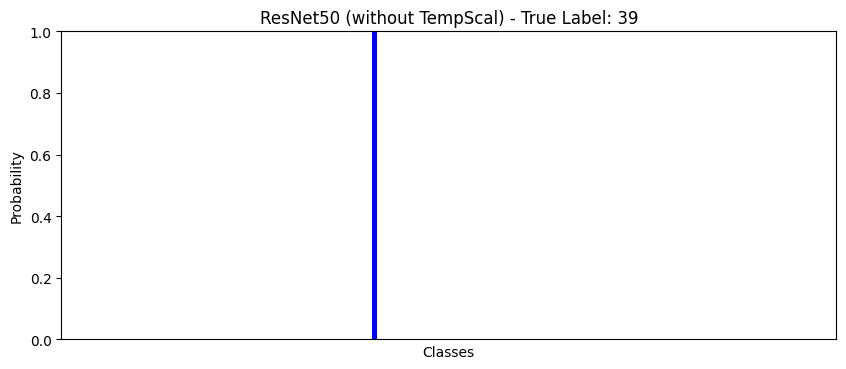

In [3]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

test_iter = iter(test_loader)
image, label = next(test_iter)
image, label = image[10].to(device), label[10].item()
model.eval()

with torch.no_grad():
    logits = model(image.unsqueeze(0))  
    probabilities = F.softmax(logits, dim=1).cpu().numpy().flatten() 

num_classes = 100

plt.figure(figsize=(10, 4))
plt.bar(range(num_classes), probabilities, color='blue')
plt.xlabel("Classes")
plt.ylabel("Probability")
plt.title(f"ResNet50 (without TempScal) - True Label: {label}")
plt.ylim(0, 1)
plt.xticks([]) 
plt.show()

In [4]:
import torch
from torch import nn, optim
from torch.nn import functional as F

class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model,tempreture):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.tempreture = tempreture
        self.temperature = nn.Parameter(torch.ones(1) * tempreture)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self


class _ECELoss(nn.Module):
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

Before temperature - NLL: 0.001, ECE: 0.001
Optimal temperature: 4.766
After temperature - NLL: 2.007, ECE: 0.862


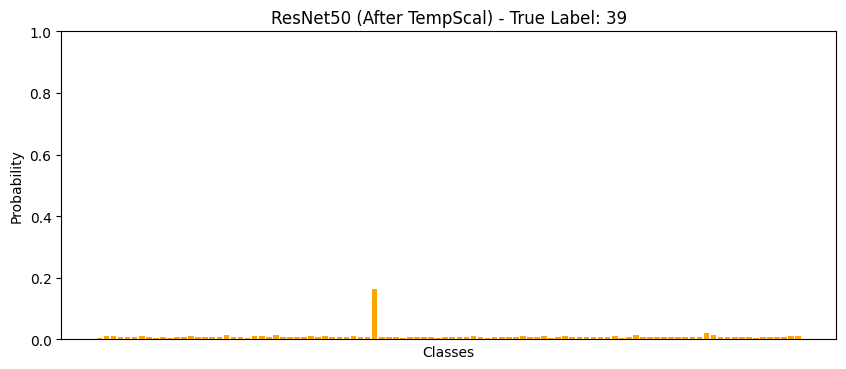

In [8]:
model_with_temp = ModelWithTemperature(model, tempreture = 5.0).to(device)
model_with_temp.set_temperature(train_loader)

model_with_temp.eval()
with torch.no_grad():
    logits = model_with_temp(image.unsqueeze(0)) 
    probabilities_temp = F.softmax(logits, dim=1).cpu().numpy().flatten() 

plt.figure(figsize=(10, 4))
plt.bar(range(num_classes), probabilities_temp, color='orange')
plt.xlabel("Classes")
plt.ylabel("Probability")
plt.title(f"ResNet50 (After TempScal) - True Label: {label}")
plt.ylim(0, 1)
plt.xticks([]) 
plt.show()